![logo](./figures/LogoLine_horizon_C3S.png)

# Cooling Degree Days

This Jupyter Notebook calculates the index **cd** (cooling_degree_days) for the CMIP6-CMCC_ESM2 model.

For quick demonstration purposes, only one year from the future period (the year 2080) is calculated for a specific region (Spain)

First, the raw CMIP6 model is downloaded from the CDS, then the index is calculated, and the results are compared with the ["Gridded dataset underpinning the Copernicus Interactive Climate Atlas"](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview), also downloaded from the CDS.

### Load Python packages and clone and install the c3s-atlas GitHub repository from the ecmwf-projects

Clone (`git clone`) the [c3s-atlas](https://github.com/ecmwf-projects/c3s-atlas) repository and install them (`pip install -e .`).

Further details on how to clone and install the repository are available in the [requirements](https://github.com/ecmwf-projects/c3s-atlas?tab=readme-ov-file#requirements)

In [1]:
import cdsapi
import os
from pathlib import Path
import xarray as xr
import xclim
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from c3s_atlas.utils import (
    extract_zip_and_delete,
    plot_month
)
from c3s_atlas.fixers import (
    apply_fixers,
    standard_names,
)
from c3s_atlas.indexes import (
    heating_degree_days,
    cooling_degree_days,
)
import c3s_atlas.interpolation as xesmfCICA

### Download climate data with the CDS API
- Catalogue: 
    - [CMIP6 climate projections](https://cds.climate.copernicus.eu/datasets/projections-cmip6?tab=overview)

In [24]:
cdsapi_url= "https://cds.climate.copernicus.eu/api"
cdsapi_key= ""

In [ ]:
c = cdsapi.Client(url=cdsapi_url, key=cdsapi_key)

> ⚠️ **Warning: Exposed API Credentials**
>
> For security reasons, it is not recommended to hardcode your Copernicus Climate Data Store (CDS) API credentials — such as `cdsapi_url` and `cdsapi_key` — directly in notebooks.
>
> Instead, it is best to store them securely in a `.cdsapirc` file located in your home directory.
>
> 📄 More info: [CDS API - How to use the API](https://cds.climate.copernicus.eu/how-to-api)

In [4]:
# define some global attributes for the CDS-API
CMIP6_years = {
    "ssp5_8_5": ["2080"],
}
# variables
variables = {
    't': 'near_surface_air_temperature', 
    'tx': 'daily_maximum_near_surface_air_temperature',
    'tn': 'daily_minimum_near_surface_air_temperature'
}
# directory to download the files
file_dest_CMIP6 = Path('./data/CMIP6')

In [5]:
months = [
    '01', '02', '03',
    '04', '05', '06',
    '07', '08', '09',
    '10', '11', '12'
]
        
days = [
    '01', '02', '03',
    '04', '05', '06',
    '07', '08', '09',
    '10', '11', '12',
    '13', '14', '15',
    '16', '17', '18',
    '19', '20', '21',
    '22', '23', '24',
    '25', '26', '27',
    '28', '29', '30', '31'
]

In [ ]:
os.makedirs(file_dest_CMIP6, exist_ok=True)

for experiment in CMIP6_years.keys():
    for year in CMIP6_years[experiment]:
        for var in variables.keys():
            path_zip = file_dest_CMIP6 / f"CMIP6_{var}_{experiment}_{year}.zip"
            c.retrieve(
                'projections-cmip6',
                {
                    'format': 'zip',
                    'temporal_resolution': 'daily',
                    'variable': variables[var],
                    'experiment': experiment,
                    'model': 'cmcc_esm2',
                    'year': year,
                    'month': months,
                    'day': days,
                },
                path_zip)
            # Extract zip file into the specified directory and remove zip
            extract_zip_and_delete(path_zip) 

### Load files with xarray

- https://docs.xarray.dev/en/stable/

In [8]:
# load files
ds_t = xr.open_dataset(file_dest_CMIP6 / "CMIP6_t_ssp5_8_5_2080.nc")
ds_tx = xr.open_dataset(file_dest_CMIP6 / "CMIP6_tx_ssp5_8_5_2080.nc")
ds_tn = xr.open_dataset(file_dest_CMIP6 / "CMIP6_tn_ssp5_8_5_2080.nc")

### Homogenization
Once the data is downloaded from the CDS it undergoes a process of homogenization:
- The metadata of the **spatial coordinates** is homogenised to use standard names, in particular [lon, lat].
  
- Fix any non-standard **calendars** used in the data. This typically involves converting the calendars to the CF standard calendar (Mixed Gregorian/Julian) commonly used in climate data. 
- Convert the **units** of the data to a common format (e.g. Celsius for temperature). This prevents us from working with the same variables in different units, for example.
- Convert the **longitude** values from the [0, 360] format to the [-180, 180] one. This is done to ensure that the longitude variable is common between the different datasets.
- **Aggregated to the required temporal resolution**. For example, hourly datasets (such as ERA5, ERA5-Land, WFDE5, etc.) will be resampled to daily resolution. This involves using a temporal aggregation method, such as taking the maximum or minimum value for a given variable. As part of this last step, some variable transformations are necessarily applied. For instance, fluxes variables in ERA5 are accumulated, and therefore, the last hour of the day represent daily accumulations. To mention another case, the surface wind is computed as a combination of both the u- and v-components.

In [9]:
project_id = "CMIP6"
variable = 'tas'
var_mapping = {
            "dataset_variable": {"tas": "data"},
            "aggregation": {"data": "mean"},
        }
ds_t = apply_fixers(ds_t, variable, project_id, var_mapping)

2025-05-15 19:55:15,852 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-05-15 19:55:15,866 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 81MB
Dimensions:    (time: 365, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 3kB 2080-01-01 12:00:00 ... 2080-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 6kB ...
    lat_bnds   (lat, bnds) float64 3kB ...
    lon_bnds   (lon, bnds) float64 5kB ...
    tas        (time, lat, lon) float32 81MB ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0


In [10]:
project_id = "CMIP6"
variable = 'tasmax'
var_mapping = {
            "dataset_variable": {"tasmax": "data"},
            "aggregation": {"data": "mean"},
        }
ds_tx = apply_fixers(ds_tx, variable, project_id, var_mapping)

2025-05-15 19:55:16,710 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-05-15 19:55:16,715 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 81MB
Dimensions:    (time: 365, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 3kB 2080-01-01 12:00:00 ... 2080-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 6kB ...
    lat_bnds   (lat, bnds) float64 3kB ...
    lon_bnds   (lon, bnds) float64 5kB ...
    tasmax     (time, lat, lon) float32 81MB ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0


In [11]:
project_id = "CMIP6"
variable = 'tasmin'
var_mapping = {
            "dataset_variable": {"tasmin": "data"},
            "aggregation": {"data": "mean"},
        }
ds_tn = apply_fixers(ds_tn, variable, project_id, var_mapping)

2025-05-15 19:55:17,354 — Homogenization-fixers — INFO — Dataset has already the correct names for its coordinates
2025-05-15 19:55:17,362 — Homogenization-fixers — INFO — Fixing calendar for <xarray.Dataset> Size: 81MB
Dimensions:    (time: 365, bnds: 2, lat: 192, lon: 288)
Coordinates:
  * time       (time) object 3kB 2080-01-01 12:00:00 ... 2080-12-31 12:00:00
  * lat        (lat) float64 2kB -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 2kB 0.0 1.25 2.5 3.75 ... 355.0 356.2 357.5 358.8
    height     float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object 6kB ...
    lat_bnds   (lat, bnds) float64 3kB ...
    lon_bnds   (lon, bnds) float64 5kB ...
    tasmin     (time, lat, lon) float32 81MB ...
Attributes: (12/48)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            ScenarioMIP
    branch_method:          standard
    branch_time_in_child:   60225.0
    branch_time_in_parent:  60225.0


### Calculate cd using in-house functions indexes. 
Some indices are not implemented in open-source Python libraries or require custom ([in-house](https://github.com/ecmwf-projects/c3s-atlas/tree/main/c3s_atlas#c3s_atlasin-house-python-functions)) implementations to enhance operability for large-scale index calculations. **cooling_degree_days** in-house functions resample the index to annual resolutions using the argument ('YS'). See [pandas timeseries](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) for more temporal resampling options.

In [12]:
ds_cd = cooling_degree_days(tas = ds_t['tas'], 
                            tasmax = ds_tx['tasmax'], 
                            tasmin = ds_tn['tasmin'],
                            freq = 'YS',
                            thresh = 22)

"freq" attribute indicates output time frequency following [pandas timeserie codes](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects)

In [13]:
# Convert DataArray to Dataset with specified variable name
ds_cd = ds_cd.to_dataset(name='cd')
ds_cd = standard_names(ds_cd)

### Interpolation to a common and regular grid using xESMF
A wrapper for the [xESMF](https://xesmf.readthedocs.io/en/stable/) Python package was developed within the framework of the C3S Atlas project to extend its functionalities to all datasets (regular, curvilinear, etc.)

In [14]:
# interpolate data
int_attr = {'interpolation_method' : 'conservative_normed', 
            'lats' : np.arange(-89.5, 90.5, 1),
            'lons' : np.arange(-179.5, 180.5, 1),
            'var_name' : 'cd'
}

In [15]:
INTER = xesmfCICA.Interpolator(int_attr)

In [ ]:
ds_cd_i = INTER(ds_cd)

### Download climate data with the CDS API
- Catalogue: [Gridded dataset underpinning the Copernicus Interactive Climate Atlas](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview)

In [17]:
project = "CMIP6"
scenario = "ss585"
var = 'cd'
# directory to download the files
dest = Path('./data/CMIP6')
os.makedirs(dest, exist_ok=True)

##### Download SSP scenario

In [ ]:
filename = 'cd_CMIP6_ss585_yr_201501-210012.zip'
dataset = "multi-origin-c3s-atlas"
request = {
    'origin': 'cmip6',
    'experiment': 'ssp5_8_5',
    'domain': 'global',
    'variable': 'annual_cooling_degree_days',
    'area': [44.5, -9.5, 35.5, 3.5]
}

c.retrieve(dataset, request).download(dest / filename)
extract_zip_and_delete(dest / filename) 

In [19]:
# load data with xarray
ds_cd_C3S_Atlas = xr.open_dataset(dest /"cd_CMIP6_ss585_yr_201501-210012.nc")

In [20]:
# select member (note than member names in the "Copernicus Interactive Climate Atlas: gridded monthly dataset" 
# are remappend to follow the DRS as much as possible)
select_member = [
    str(mem.data) for mem in ds_cd_C3S_Atlas.member_id if "cmcc-esm2" in str(mem.data).lower()
][0]
print(select_member)

CMCC_CMCC-ESM2_r1i1p1f1


In [21]:
ds_cd_C3S_Atlas_member_year = ds_cd_C3S_Atlas.sel(
    member = np.where(ds_cd_C3S_Atlas.member_id == select_member)[0], 
    time = "2080"
)

#### Plot results
Comparison of the results obtained with present Jupyter notebook and the reference [C3S Atlas Dataset](https://cds.climate.copernicus.eu/datasets/multi-origin-c3s-atlas?tab=overview) underpinning the C3S Atlas. A geographical subset focusing on Spain is selected to show the results.

In [22]:
zoomin_extent = [-9.5, 3.5, 35.5, 44.5]

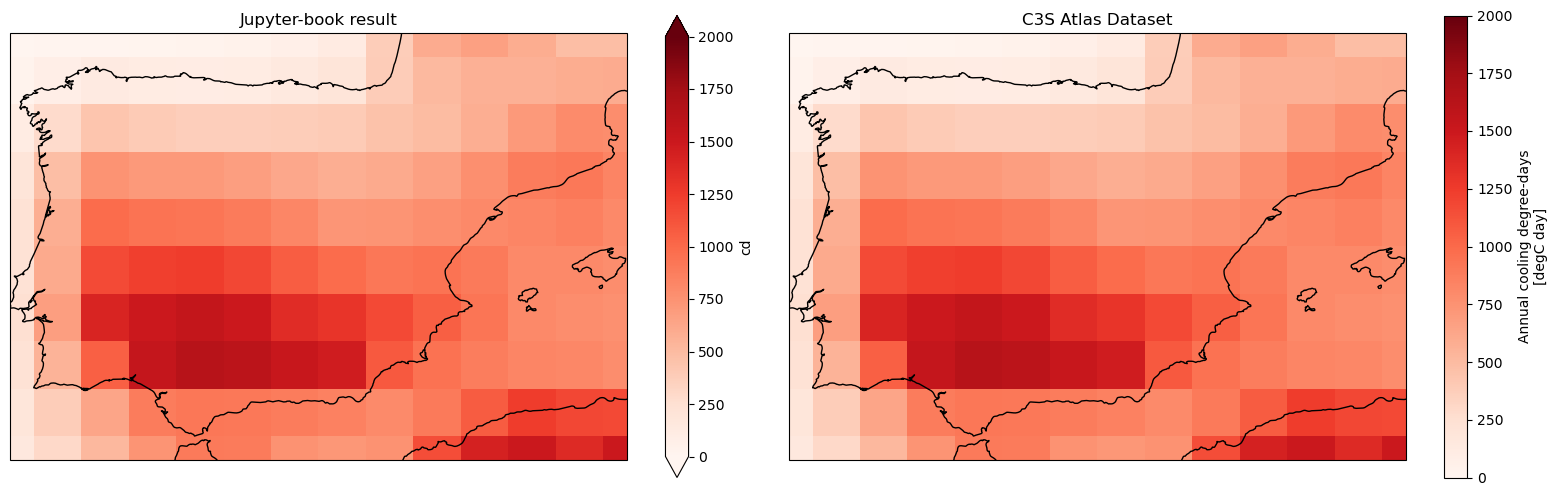

In [23]:
# zoom for Spain
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(nrows=1, ncols=2, subplot_kw={'projection': proj}, figsize=(20, 6))

ds_cd_i['cd'].plot(ax = ax[0], cmap = 'Reds', vmin = 0, vmax = 2000)
ax[0].set_title('Jupyter-book result')
ax[0].set_extent(zoomin_extent)
ax[0].coastlines()

ds_cd_C3S_Atlas_member_year['cd'].plot(ax = ax[1], cmap = 'Reds', vmin = 0, vmax = 2000)
ax[1].set_title('C3S Atlas Dataset')
ax[1].set_extent(zoomin_extent)
ax[1].coastlines()

plt.subplots_adjust(wspace=0.01, hspace=0.1) 